In [1]:
import seaborn as sns
# set font-scale
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [3]:
df = load_csvs_into_df('./')

In [4]:
# only keep relevant columns
df = df[['seed','job_type_mod','test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC','protected_attr_percent']]

In [5]:
df = pd.melt(df, id_vars=['seed','protected_attr_percent','job_type_mod'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])

In [6]:
# replace variable names
print(df.variable.unique())
df.variable = df.variable.str.replace('test/lungOpacity_young_subgroupAUROC','young')
df.variable = df.variable.str.replace('test/lungOpacity_old_subgroupAUROC','old')
df.head()

['test/lungOpacity_young_subgroupAUROC'
 'test/lungOpacity_old_subgroupAUROC']


,seed,protected_attr_percent,job_type_mod,variable,value
0,1,0.5,msdefault,young,0.6410
1,1,0.5,ms200-250-300-400,young,0.6364
2,1,0.5,ms25-50-75-100,young,0.6422
3,1,0.5,ms50,young,0.6276
4,1,0.5,ms100-150,young,0.5782


In [7]:
# replace all job_type_mods of "msdefault" with "msdefault-300"
df.job_type_mod = df.job_type_mod.str.replace('msdefault','msdefault-300')
# regex to get the digits after the last '-' at the end of the string
df['temp'] = df.job_type_mod.str.extract(r'-?(\d+)$')
# cast to int
df['temp'] = abs(df.temp.astype(int))
# soft by temp
df = df.sort_values(by=['temp'])

In [8]:
# sort list ascending
fractions = df.protected_attr_percent.unique()
fractions.sort()

In [9]:
job_type_mods = df.job_type_mod.unique()

best model size: ms50


/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

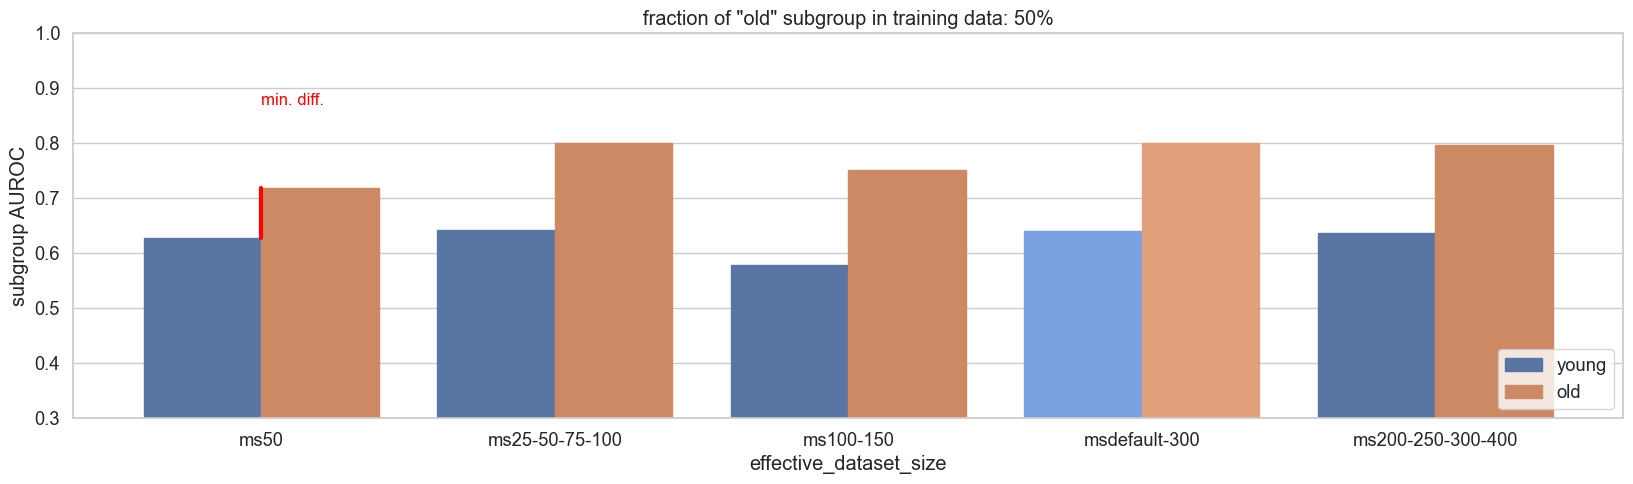

In [10]:
for f in fractions:
    plt.figure(figsize=(20,5))
    sub = df[df.protected_attr_percent==f]
    # group by weight
    sub_grouped = sub.groupby(['job_type_mod','variable']).mean().reset_index()
    # over all weights get weight with minimum dist between young and old subgroup AUROC
    min_dist = np.inf
    best_ms = None
    best_ms_max = None
    best_ms_min = None
    for idx, w in enumerate(job_type_mods):
        sub_grouped_w = sub_grouped[sub_grouped.job_type_mod==w]
        # compute dist between max and min of value column
        dist = sub_grouped_w.value.max() - sub_grouped_w.value.min()
        if dist < min_dist:
            min_dist = dist
            best_ms = idx
            best_ms_max = sub_grouped_w.value.max()
            best_ms_min = sub_grouped_w.value.min()
    print(f"best model size: {job_type_mods[best_ms]}")
    g = sns.barplot(data=sub, x="job_type_mod", y="value", hue="variable")
    # create vertical line at best weight
    plt.plot([best_ms, best_ms], [best_ms_min, best_ms_max], color='red', linestyle='-', linewidth=3)
    # add text at same location
    custom_colors = ["#5975A4"]*3 + ["#79a0e0"] + ["#5975A4"] + ["#CC8963"]*3 + ["#e1a07a"] + ["#CC8963"]
    for i, bar in enumerate(g.patches):
        bar.set_color(custom_colors[i])
    plt.text(best_ms * 1, 0.87, f'min. diff.', fontsize=12, color="red")
    plt.title(f'fraction of "old" subgroup in training data: {f*100:.0f}%')
    # set axis labels
    plt.ylim(0.3,1)
    plt.xlabel('effective_dataset_size')
    plt.ylabel('subgroup AUROC')
    plt.legend(loc="lower right")
    plt.show()